# Internal stability of Runge-Kutta methods

Internal stability deals with the growth of errors (such as roundoff) introduced at the Runge-Kutta stages during a single Runge-Kutta step.  It is usually important only for methods with a large number of stages, since that is when the internal amplification factors can be large.  An excellent explanation of internal stability is given in [this paper](http://oai.cwi.nl/oai/asset/1652/1652A.pdf).  Here we demonstrate some tools for studying internal stability in NodePy.

First, let's load a couple of RK methods:

In [ ]:
from nodepy import rk
import numpy as np
import matplotlib.pyplot as plt

rk4 = rk.loadRKM('RK44')
ssprk4 = rk.loadRKM('SSP104')
print(rk4)
print(ssprk4)

Classical RK4
The original four-stage, fourth-order method of Kutta
 0   |
 1/2 | 1/2
 1/2 |      1/2
 1   |           1
_____|____________________
     | 1/6  1/3  1/3  1/6
SSPRK(10,4)
The optimal ten-stage, fourth order SSP Runge-Kutta method
 0    |
 1/6  | 1/6
 1/3  | 1/6   1/6
 1/2  | 1/6   1/6   1/6
 2/3  | 1/6   1/6   1/6   1/6
 1/3  | 1/15  1/15  1/15  1/15  1/15
 1/2  | 1/15  1/15  1/15  1/15  1/15  1/6
 2/3  | 1/15  1/15  1/15  1/15  1/15  1/6   1/6
 5/6  | 1/15  1/15  1/15  1/15  1/15  1/6   1/6   1/6
 1    | 1/15  1/15  1/15  1/15  1/15  1/6   1/6   1/6   1/6
______|____________________________________________________________
      | 1/10  1/10  1/10  1/10  1/10  1/10  1/10  1/10  1/10  1/10
      |       2/9               5/18  1/3                     1/6


## Absolute stability regions

First we can use NodePy to plot the region of absolute stability for each method.  The absolute stability region is the set

\begin{align} \label{1}
\{ z \in C : |\phi (z)|\le 1 \}
\end{align}

where $\phi(z)$ is the *stability function* of the method:

<center>$1 + z b^T (I-zA)^{-1}$</center>

If we solve $u'(t) = \lambda u$ with a given method, then $z=\lambda \Delta t$ must lie inside this region or the computation will be unstable.

         4          3       2
0.04167 x + 0.1667 x + 0.5 x + 1 x + 1


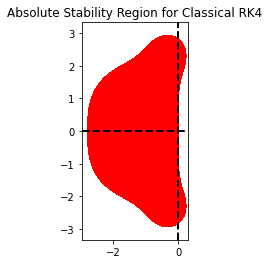

In [2]:
p,q = rk4.stability_function()
print(p)
h1 = rk4.plot_stability_region()

           10             9            8             7           6
3.969e-09 x  + 2.381e-07 x + 6.43e-06 x + 0.0001029 x + 0.00108 x
            5           4          3       2
 + 0.00787 x + 0.04167 x + 0.1667 x + 0.5 x + 1 x + 1


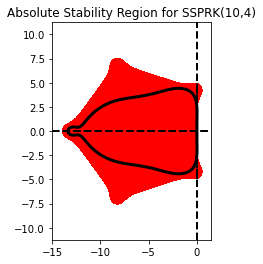

In [3]:
p,q = ssprk4.stability_function()
print(p)
h2 = ssprk4.plot_stability_region()

# Internal stability

The stability function tells us by how much errors from one step are amplified in the next one.  This is important since we introduce truncation errors at every step.  However, we also introduce roundoff errors at the each stage within a step.  Internal stability tells us about the growth of those.  Internal stability is typically less important than (step-by-step) absolute stability for two reasons:

 - Roundoff errors are typically much smaller than truncation errors, so moderate amplification of them typically is not significant
 - Although the propagation of stage errors within a step is governed by internal stability functions, in later steps these errors are propagated according to the (principal) stability function

Nevertheless, in methods with many stages, internal stability can play a key role.

Questions: *In the solution of PDEs, large spatial truncation errors enter at each stage.  Does this mean internal stability becomes more significant?  How does this relate to stiff accuracy analysis and order reduction?*

## Internal stability functions

We can write the equations of a Runge-Kutta method compactly as

\begin{align}
y & = u^n e + h A F(y) \\
u^{n+1} & = u^n + h b^T F(y),
\end{align}

where $y$ is the vector of stage values, $u^n$ is the previous step solution, $e$ is a vector with all entries equal to 1, $h$ is the step size, $A$ and $b$ are the coefficients in the Butcher tableau, and $F(y)$ is the vector of stage derivatives.  In floating point arithmetic, roundoff errors will be made at each stage.  Representing these errors by a vector $r$, we have

<center>$y = u^n e + h A F(y) + r.$</center>

Considering the test problem $F(y)=\lambda y$ and solving for $y$ gives

<center>$y = u^n (I-zA)^{-1}e + (I-zA)^{-1}r,$</center>

where $z=h\lambda$.  Substituting this result in the equation for $u^{n+1}$ gives

<center>$u^{n+1} = u^n (1 + zb^T(I-zA)^{-1}e) + zb^T(I-zA)^{-1}r = \psi(z) u^n + \theta(z)^T r.$</center>

Here $\psi(z)$ is the *stability function* of the method, that we already encountered above.  Meanwhile, the vector $\theta(z)$ contains the *internal stability functions* that govern the amplification of roundoff errors $r$ within a step:

<center>$\theta(z) = z b^T (I-zA)^{-1}.$</center>

Let's compute $\theta$ for the classical RK4 method:

In [4]:
theta=rk4.internal_stability_polynomials()
theta

[poly1d([1/12, 1/6, 1/3, 0], dtype=object),
 poly1d([1/6, 1/3, 0], dtype=object),
 poly1d([1/6, 0], dtype=object)]

In [5]:
for theta_j in theta:
    print(theta_j)

         3          2
0.08333 x + 0.1667 x + 0.3333 x
        2
0.1667 x + 0.3333 x
 
0.1667 x


Thus the roundoff errors in the first stage are amplified by a factor $z^4/24 + z^3/12 + z^2/6 + z/6$, while the errors in the last stage are amplified by a factor $z/6$.

## Internal instability

Usually internal stability is unimportant since it relates to amplification of roundoff errors, which are very small.  Let's think about when things can go wrong in terms of internal instability.  If $|\theta(z)|$ is of the order $1/\epsilon_{machine}$, then roundoff errors could be amplified so much that they destroy the accuracy of the computation.  More specifically, we should be concerned if $|\theta(z)|$ is of the order $tol/\epsilon_{machine}$ where $tol$ is our desired error tolerance.  Of course, we only care about values of $z$ that lie inside the absolute stability region $S$, since internal stability won't matter if the computation is not absolutely stable.

We can get some idea about the amplification of stage errors by plotting the curves $|\theta(z)|=1$ along with the stability region.  Ideally these curves will all lie outside the stability region, so that all stage errors are damped.

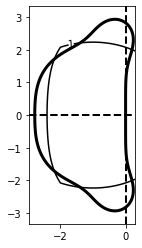

In [6]:
rk4.internal_stability_plot()

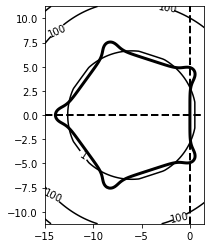

In [7]:
ssprk4.internal_stability_plot()

For both methods, we see that some of the curves intersect the absolute stability region, so some stage errors are amplified.  But by how much?  We'd really like to know the maximum amplification of the stage errors under the condition of absolute stability.  We therefore define the *maximum internal amplification factor* $M$:

<center>$M = \max_j \max_{z \in S} |\theta_j(z)|$</center>

In [8]:
print(rk4.maximum_internal_amplification())
print(ssprk4.maximum_internal_amplification())

(1.6718324799475162, 0.0)
(2.386110272389574, 0.6)


We see that both methods have small internal amplification factors, so internal stability is not a concern in either case.  This is not surprising for the method with only four stages; it is a surprisingly good property of the method with ten stages.

Questions: *Do SSP RK methods always (necessarily) have small amplification factors?  Can we prove it?*

Now let's look at some methods with many stages.

## Runge-Kutta Chebyshev methods

The paper of Verwer, Hundsdorfer, and Sommeijer deals with RKC methods, which can have very many stages.  The construction of these methods is implemented in NodePy, so let's take a look at them.  The functions `RKC1(s)` and `RKC2(s)` construct RKC methods of order 1 and 2, respectively, with $s$ stages.

In [9]:
s = 4
rkc = rk.RKC1(s)
print(rkc)

Runge-Kutta-Chebyshev (4,1)

 0    |
 1/16 | 1/16
 1/4  | 1/8   1/8
 9/16 | 3/16  1/4   1/8
______|________________________
      | 1/4   3/8   1/4   1/8


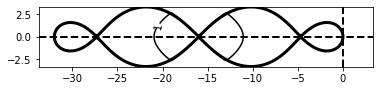

In [10]:
rkc.internal_stability_plot()

It looks like there could be some significant internal amplification here.  Let's see:

In [11]:
rkc.maximum_internal_amplification()

(3.888032523476453, 4.0)

Nothing catastrophic.  Let's try a larger value of $s$:

In [12]:
s = 20
rkc = rk.RKC1(s)
rkc.maximum_internal_amplification()

(10.693352186111435, 20.0)

As promised, these methods seem to have good internal stability properties.  What about the second-order methods?

In [13]:
s = 20
rkc = rk.RKC2(s)
rkc.maximum_internal_amplification()

(29.805924630882497, 25.27)

Again, nothing catastrophic.  We could take $s$ much larger than 20, but the calculations get to be rather slow (in Python) and since we're using floating point arithmetic, the accuracy deteriorates.

Remark: *we could do the calculations in exact arithmetic using Sympy, but things would get even slower.  Perhaps there are some optimizations that could be done to speed this up.  Or perhaps we should use Mathematica if we need to do this kind of thing.*

Remark 2: *of course, for the RKC methods the internal stability polynomials are shifted Chebyshev polynomials.  So we could evaluate them directly in a stable manner using the three-term recurrence (or perhaps scipy's special functions library).  This would also be a nice check on the calculations above.*

## Other methods with many stages

Three other classes of methods with many stages have been implemented in NodePy:

 - SSP families
 - Integral deferred correction (IDC) methods
 - Extrapolation methods

### SSP Families

(1.0312970542011217, 0.95)

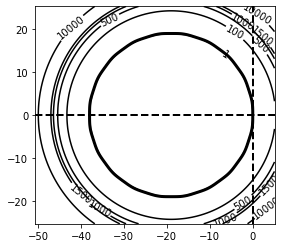

In [14]:
s = 20
ssprk = rk.SSPRK2(s)
ssprk.internal_stability_plot()
ssprk.maximum_internal_amplification()

(2.0532584966003986, 1.0)

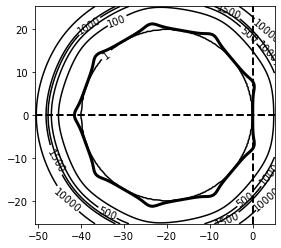

In [15]:
s = 25 # # of stages
ssprk = rk.SSPRK3(s)
ssprk.internal_stability_plot()
ssprk.maximum_internal_amplification()

The SSP methods seem to have excellent internal stability properties.

### IDC methods

26


(7.745194401404304, 0.0)

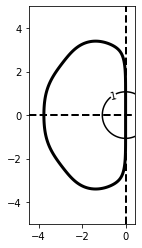

In [16]:
p = 6 #order
idc = rk.DC(p-1)
print(len(idc))
idc.internal_stability_plot()
idc.maximum_internal_amplification()

IDC methods also seem to have excellent internal stability.

### Extrapolation methods

16


(189.8568730592554, 130.20833333333334)

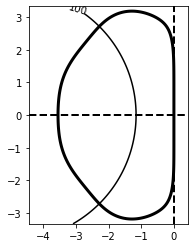

In [17]:
p = 6 #order
ex = rk.extrap(p)
print(len(ex))
ex.internal_stability_plot()
ex.maximum_internal_amplification()

Not so good.  Let's try a method with even more stages (this next computation will take a while; go stretch your legs).

In [18]:
p = 10 #order
ex = rk.extrap(p)
print(len(ex))
ex.maximum_internal_amplification()

46


(53764.206493020814, 13315.250793650794)

Now we're starting to see something that might cause trouble, especially since such high order extrapolation methods are usually used when extremely tight error tolerances are required.  Internal amplification will cause a loss of about 5 digits of accuracy here, so the best we can hope for is about 10 digits of accuracy in double precision.  Higher order extrapolation methods will make things even worse.  How large are their amplification factors?  (Really long calculation here...)

In [19]:
pmax = 12
ampfac = np.zeros(pmax+1)
for p in range(1, pmax+1):
    ex = rk.extrap(p)
    ampfac[p] = ex.maximum_internal_amplification()[0]
    print(p, ampfac[p])

1 0.0
2 2.193928615790812
3 6.173740624457357
4 25.594706632818742


5 114.62256593507632


6 189.8568730592554


7 629.1679641391079


8 2541.5350046110575


9 11602.92082338415


10 53764.206493020814


11 246176.07962544935


12 332603.423069675


Text(0, 0.5, 'Amplification factor')

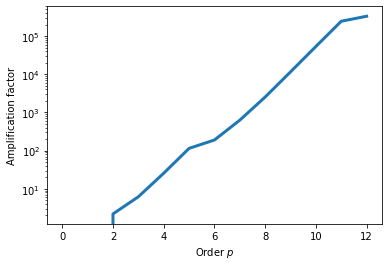

In [20]:
plt.semilogy(ampfac, linewidth=3)
plt.xlabel(r"Order $p$")
plt.ylabel(r"Amplification factor")

We see roughly geometric growth of the internal amplification factor as a function of the order $p$.  It seems clear that very high order extrapolation methods applied to problems with high accuracy requirements will fall victim to internal stability issues.